# Experimento para analizar la estrategia de un equipo
En el presente experimento se va a tratar de analizar la estrategia que un equipo de fútbol a lo largo de una temporada mediante técnicas de aprendizaje automático. Es importante aclarar que debido al componente aleatorio de los algoritmos de agrupamiento es posible que las interpretaciones no tengan sentido con los resultados que se obtienen.

In [1]:
# Librerías necesarias
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import calinski_harabasz_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import json
from FCPython import createPitch
import pandas as pd
import math
# Paleta de colores para la representación
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(0,12)]
# Medidas del terreno de juego (en yardas)
pitchLengthX=120
pitchWidthY=80

## Primera aproximación
Antes de desarrollar el experimento es necesario realizar un primer acercamiento con un solo partido, ya que así se puede pulir fácilmente la posterior implementación. Se procede con la lectura de datos de las localizaciones en el terreno de juego, que ya han sido preparadas.

In [2]:
# Función que obtiene las coordenadas de los eventos de un partido
def read_match_events(match_id):
    file_name = 'open-data/data/events/'+str(match_id)+'.json'
    with open(file_name,encoding='UTF-8') as data_file:
        data = json.load(data_file,encoding='UTF-8')
    df = pd.json_normalize(data, sep = '_').assign(match_id = file_name[:-5])
    eventos_barsa = df.loc[df['team_name'] == 'Barcelona'].set_index('id') # Se escogen los del F.C. Barcelona
    # Extracción de las localizaciones de los eventos
    all_coords = []
    juego_parado = ['Corner','Free Kick','Goal Kick','Kick Off','Throw-in'] # Tipos de eventos que se evitan
    for i,evento in eventos_barsa.iterrows():
        if not math.isnan(evento['position_id']):
            jugador = evento['position_id']
            if type(evento['location']).__name__ == "list" and jugador != 1:
                if evento['pass_type_name'] in juego_parado and type(evento['pass_end_location']).__name__ == "list":
                    lugar = evento['pass_end_location']
                else:
                    lugar = evento['location']
                    if type(evento['pass_end_location']).__name__ == "list":
                        new_lugar = evento['pass_end_location']
                        all_coords.append(new_lugar)
                    if type(evento['carry_end_location']).__name__ == "list":
                        new_lugar = evento['carry_end_location']
                        all_coords.append(new_lugar)
                all_coords.append(lugar)
    return all_coords

In [4]:
match_id = 9592
event_locations = read_match_events(match_id)

Los datos sobre los que se aplicará la técnica de *machine learning* se han introducido en un *array* con tantas filas como eventos y con dos columnas. Están preparados para aplicar sobre ellos un proceso de ***clustering*** para el que se tomarán unos valores de inicio los cuales se corresponden con la posición de los jugadores en el once típico del F.C. Barcelona. Aunque, en primer lugar, la inicialización de los centroides será aleatoria. El algoritmo escogido es el K-medias. 

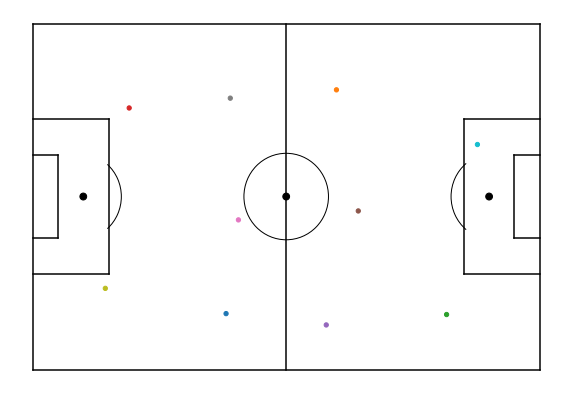

In [5]:
cluster = KMeans(n_clusters=10).fit(event_locations)
# Representación
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
for index,pos in enumerate(cluster.cluster_centers_):
    event = plt.Circle((pos[0],pitchWidthY-pos[1]),0.5,color=colors[index])
    ax.add_patch(event)
fig.set_size_inches(10, 7)
plt.show()
#fig.savefig('visual/cluster_all_'+str(match_id)+'.png')

In [6]:
cluster.cluster_centers_

array([[ 45.77303371,  67.07191011],
       [ 71.88605108,  15.32416503],
       [ 97.93960396,  67.28613861],
       [ 22.85831063,  19.51771117],
       [ 69.47590361,  69.69277108],
       [ 77.05223881,  43.33208955],
       [ 48.69722222,  45.4       ],
       [ 46.77330896,  17.24862888],
       [ 17.20842491,  61.23406593],
       [105.23470149,  27.96865672]])

Si comparamos los centroides obtenidos con una formación se podría decir que se trata de una 2-3-3-2. Partiendo de la hipótesis por la cual los laterales de equipos tan ofensivos como el del objeto de estudio tienen mucha actividad de ataque, se podría decir que la alineación con la que se inició el juego era una 4-4-2 o 4-2-3-1.

El siguiente paso, para un mejor entendimiento, se representan los eventos asociados a cada centroide, los cuales se identifican con un color.

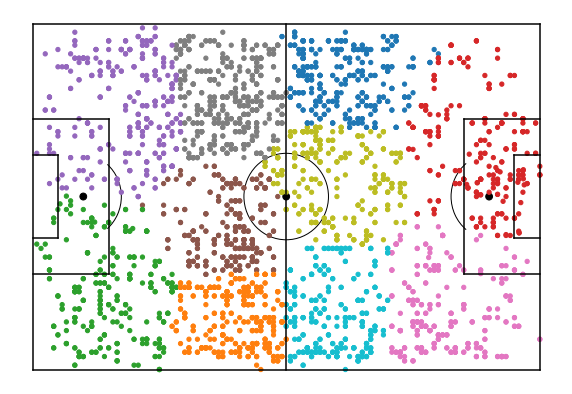

In [7]:
cluster_selection = KMeans(n_clusters=10).fit_predict(event_locations)
# Representación
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
points_and_centers = zip(event_locations,cluster_selection)
for pos in points_and_centers:
    location = pos[0]
    cent = pos[1]
    event = plt.Circle((location[0],pitchWidthY-location[1]),0.5,color=colors[cent])
    ax.add_patch(event)
fig.set_size_inches(10, 7)
plt.show()
# fig.savefig('visual/cluster_all_byplayer_'+str(match_id)+'.png')

La distribución de los eventos toma forma de una cuadrícula, algo que puede no llegar a tener sentido puesto que normalmente las acciones de un jugador no se suceden en un área tan delimitada. Para comprobar la invalidez de este resultado es posible obtener las acciones desarrolladas por un jugador y lo que sería su centro de masa.

In [8]:
def match_events_player(match_id,player):
    with open('./open-data/data/events/{}.json'.format(match_id), encoding='utf-8') as f:
        EVENTOS = json.load(f)
    EVENTOS = pd.json_normalize(EVENTOS, sep='_')
    player_events = EVENTOS[(EVENTOS['player_name'] == player)&(EVENTOS['location'].notnull())].copy()
    res = pd.DataFrame({'location_x': player_events['location'].apply(lambda x: x[0]).tolist(),
                        'location_y': player_events['location'].apply(lambda x: x[1]).tolist()})
    return res

Si se aplica la función de arriba introduciendo el nombre de, por ejemplo, Lionel Messi se representan los eventos que ha protagonizado.

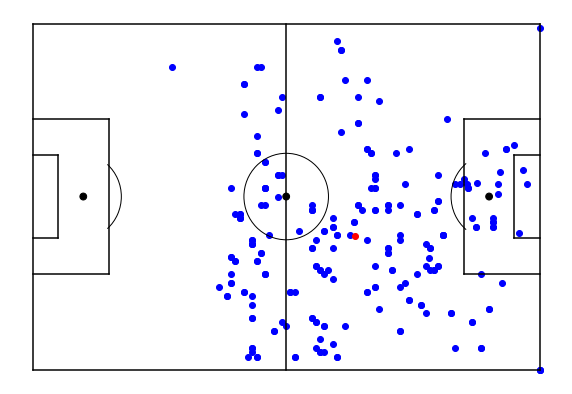

In [9]:
player = 'Lionel Andrés Messi Cuccittini'
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
messi_events = match_events_player(9592,player)
plt.scatter(messi_events['location_x'].tolist(),messi_events['location_y'].apply(lambda x: pitchWidthY-x).tolist(),c='blue')
centroid_messi = messi_events.mean()
plt.scatter(centroid_messi[0],pitchWidthY-centroid_messi[1],c='red')
fig.set_size_inches(10, 7)
plt.show()
#fig.savefig('visual/cluster_all_messi_'+str(match_id)+'.png')

Lionel Messi está presente en la gran mayoría de acciones de ataque de su equipo, por eso su centro de masas aparece centrado en el campo contrario. Viendo esta imagen es posible relacionar el cluster de color verde de la imagen de todos los eventos con este jugador.

Sin embargo, no estoy satisfecho con la distribución que toman los eventos cuando se relacionan con su centroide. Parece muy artificial y se aleja de lo que interpreto como una correcta distribución. Para tratar de mejorar ese resultado se procede con una prueba en la que se inicializan los centroides con la alineación que eligió el entrenador del FCB para ese encuentro. Se trata de una 4-4-2 clásica con la posición del delantero derecho (Messi) un poco retrasada. Dicha formación se muestra así:

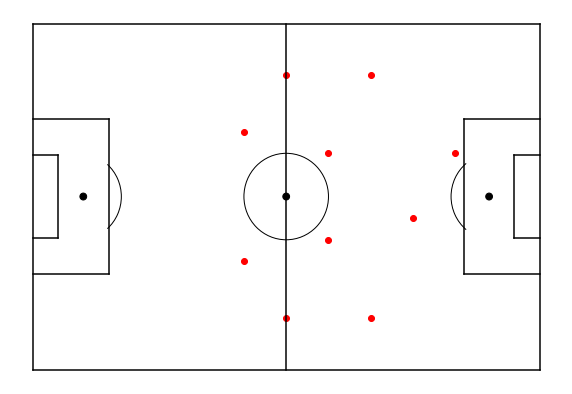

In [10]:
(fig,ax) = createPitch(120,80,'yards','black')
x = [60,50,50,60,80,70,70,80,90,100]
y = [12,25,55,68,12,30,50,68,35,50]
plt.scatter(x,y,c='red')
fig.set_size_inches(10, 7)

Lo que deriva en la siguiente distribución de las particiones.

C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


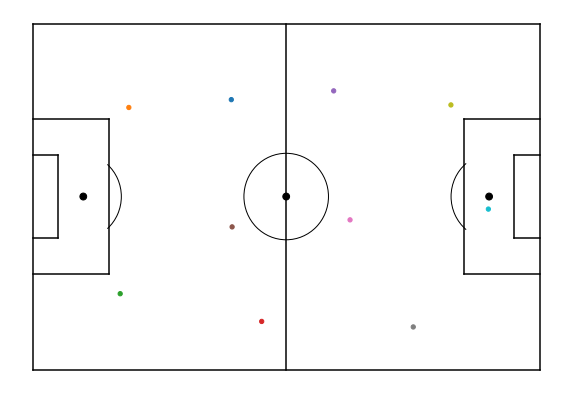

In [11]:
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
# al_442 = np.array([[45,12],[30,25],[30,55],[45,68],[75,12],[60,30],[60,50],[75,68],[90,30],[100,50]])
al_442 = np.array([[60,12],[50,25],[50,55],[60,68],[80,12],[70,30],[70,50],[90,68],[90,35],[100,50]])
cluster_selection = KMeans(n_clusters=10,init=al_442).fit(event_locations)
for i,centre in enumerate(cluster_selection.cluster_centers_.tolist()):
    event = plt.Circle((centre[0],pitchWidthY-centre[1]),0.5,color=colors[i])
    ax.add_patch(event)
fig.set_size_inches(10, 7)
plt.show()
#fig.savefig('visual/cluster_all_init_'+str(match_id)+'.png')

Con esta representación es complicado ver las diferencias, aunque es notorio el movimiento hacia arriba que ha sufrido el centroide que hemos relacionado con Messi. 

C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


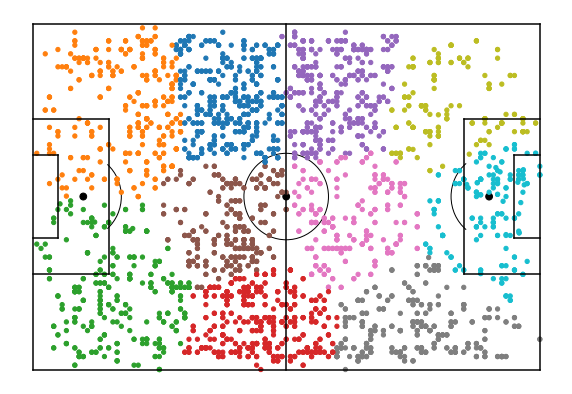

In [12]:
cluster_selection = KMeans(n_clusters=10,init=al_442).fit_predict(event_locations)
# Representación
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
points_and_centers = zip(event_locations,cluster_selection)
for pos in points_and_centers:
    location = pos[0]
    cent = pos[1]
    event = plt.Circle((location[0],pitchWidthY-location[1]),0.5,color=colors[cent])
    ax.add_patch(event)
fig.set_size_inches(10, 7)
plt.show()
# fig.savefig('visual/cluster_all_init_byplayer_'+str(match_id)+'.png')

Ahora es menos uniforme y, por lo tanto, más realista (o eso creo). Esto es una valoración totalmente cualitativa, por lo que es necesario apoyarse en datos reales aplicando métricas para poder comparar ambos resultados. Procedo a utilizar las métricas de Calinski-Harabasz y Silhouette en varios partidos (incluyendo el de la prueba) de esa misma temporada. La información se incluirá en un dataframe. Se crea una función que facilite este proceso.

In [13]:
def compare_clustering(match_ids,init_ali=None):
    data = []
    for match in match_ids:
        match_events = read_match_events(match)
        if init_ali is not None:
            cluster = KMeans(n_clusters=10,init=init_ali).fit(match_events)
        else:
            cluster = KMeans(n_clusters=10).fit(match_events)
        calinski = calinski_harabasz_score(match_events,cluster.labels_)
        silhouette = silhouette_score(match_events,cluster.labels_)
        data.append([match,calinski,silhouette])
    comp_matrix = pd.DataFrame(data=data,columns=['match_id', 'calinski_harabasz_score','silhouette_score'])      
    return comp_matrix

La función creada se aplica sobre 5 partidos entre los que se incluye el que se ha estudiado anteriormente.

In [14]:
selected_matches_ids = [9592,9870,9783,9700,9860]
comp = compare_clustering(selected_matches_ids)
comp_init = compare_clustering(selected_matches_ids,init_ali=al_442)

C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
C:\Users\jorgi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only 

Con los resultados obtenidos se calculan las diferencias entre resultados.

In [15]:
# Se incluye todo en uno
comp['init_calinski_harabasz_score'] = comp_init['calinski_harabasz_score']
comp['init_silhouette_score'] = comp_init['silhouette_score']
comp['calinski_harabasz_diff'] = comp['calinski_harabasz_score']-comp['init_calinski_harabasz_score']
comp['silhouette_diff'] = comp['silhouette_score']-comp['init_silhouette_score']
comp

,match_id,calinski_harabasz_score,silhouette_score,init_calinski_harabasz_score,init_silhouette_score,calinski_harabasz_diff,silhouette_diff
0,9592,3560.249197,0.374142,3423.653178,0.374065,136.596020,0.000077
1,9870,3044.783592,0.353716,3037.692018,0.349775,7.091573,0.003941
2,9783,3082.661645,0.365971,2776.261156,0.347221,306.400490,0.018750
3,9700,3484.187272,0.368719,3477.344972,0.371255,6.842301,-0.002536
4,9860,2902.757547,0.375689,2637.392081,0.345609,265.365466,0.030080


In [16]:
cal_har_diff = comp['calinski_harabasz_diff'].mean()
sil_diff = comp['silhouette_diff'].mean()
print('Diferencia para Calinski-Harabasz: ' + str(cal_har_diff) + '.\nDiferencia para Silhouette: ' + str(sil_diff) + '.')

Diferencia para Calinski-Harabasz: 144.45917004163258.
Diferencia para Silhouette: 0.010062344290034619.


Según esos cálculos la inicialización no ha supuesto mejora alguna, por lo que se continuará con otras pruebas.

Los resultados no son lo suficientemente satisfactorios, planteándose la posibilidad de usar otro algoritmo de agrupamiento. En esta ocasión, se va a aplicar la técnica de clustering aglomerante para buscar entre los datos aquellos grupos con más peso, los cuales identificaremos con jugadores.

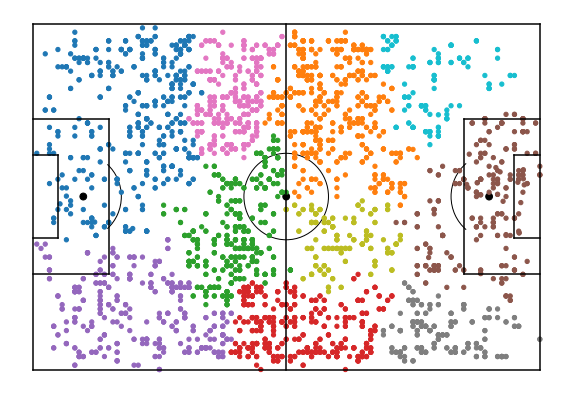

In [17]:
cluster_selection = AgglomerativeClustering(n_clusters=10).fit(event_locations)
# Representación
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
points_and_centers = zip(event_locations,cluster_selection.labels_)
for pos in points_and_centers:
    location = pos[0]
    cent = pos[1]
    event = plt.Circle((location[0],pitchWidthY-location[1]),0.5,color=colors[cent])
    ax.add_patch(event)
fig.set_size_inches(10, 7)
# fig.savefig('visual/cluster_all_aglo_'+str(match_id)+'.png')
plt.show()

Con este tipo de algoritmo de agrupamiento se describe una distribución menos uniforme, algo que se puede considerar como satisfactorio. Pero se ha de evaluar objetivamente, por lo que también se le van a aplicar las métricas anteriores a los mismos encuentros estudiados anteriormente.

In [18]:
selected_matches_ids = [9592,9870,9783,9700,9860]
data = []
for match in selected_matches_ids:
    match_events = read_match_events(match)
    cluster = AgglomerativeClustering(n_clusters=10).fit(match_events)
    calinski = calinski_harabasz_score(match_events,cluster.labels_)
    silhouette = silhouette_score(match_events,cluster.labels_)
    data.append([match,calinski,silhouette])
comp_matrix = pd.DataFrame(data=data,columns=['match_id', 'calinski_harabasz_score','silhouette_score'])      
comp_matrix

,match_id,calinski_harabasz_score,silhouette_score
0,9592,2874.889654,0.317507
1,9870,2697.488186,0.325479
2,9783,2609.737866,0.327389
3,9700,2963.875309,0.325038
4,9860,2468.474131,0.329487


In [19]:
cal_har_diff = comp_matrix['calinski_harabasz_score'].mean()
sil_diff = comp_matrix['silhouette_score'].mean()
print('Media de los resultados.\nCalinski-Harabasz: ' + str(cal_har_diff) + '\nSilhouette: ' + str(sil_diff))

Media de los resultados.
Calinski-Harabasz: 2722.893029149295
Silhouette: 0.32497989955122975


La evaluación realizada sobre el mismo conjunto de partidos expresa que la partición obtenida mediante el algoritmo de clustering aglomerante tiene un menor grado de cohesión que la proveniente del K-medias sin inicialización.

## Alineaciones únicas

El algoritmo de clustering aglomerante no ha sido de gran utilidad a la hora de mejorar el resultado del K-medias. Sin embargo, se va a volver a utilizar para obtener las distribuciones de jugadores del F.C. Barcelona únicas que se dan por temporada.

El primer paso, por lo tanto, será obtener los partidos de este equipo en una temporada determinada.

In [20]:
def match_ids_season(season):
    match_ids = []
    file_name = 'open-data/data/competitions.json'
    with open(file_name,encoding='UTF-8') as data_file:
        data = json.load(data_file,encoding='UTF-8')
    df = pd.json_normalize(data, sep = '_')
    res = df[(df['competition_name'] == 'La Liga')&(df['season_name'] == season)].copy()
    with open('open-data/data/matches/'+str(res['competition_id'].values[0])+'/'+str(res['season_id'].values[0])+'.json',encoding='utf-8') as data_file:
            data = json.load(data_file)
    for match in data:
        match_ids.append(match['match_id'])
    return match_ids

Se debe continuar aplicando el K-medias sobre los eventos de esos partidos y almacenar los centroides obtenidos.

In [21]:
season = '2017/2018'
match_ids = match_ids_season(season)

**La siguiente celda puede modificar todas las interpretaciones realizadas en el resto del experimento. Por lo tanto, si se quiere mantener la consistencia se debe ejecutar la celda posterior, diseñada para recuperar los datos de un archivo con los datos correctos.**

In [4]:
centroids = []
for match_id in ids:
    match_events = read_match_events(match_id)
    cluster_selection =  KMeans(n_clusters=10).fit(match_events)
    centroids.append(cluster_selection.cluster_centers_)

# Guardar los datos de la celda anterior para utilizarlos siempre
def write_centroids(centroids):
    centroids_to_json = []
    for c in centroids:
        centroids_to_json.append(c.tolist())
    file_name = 'data/cluster_centers_' + str(season).replace('/','_') + '.json'
    with open(file_name, 'w') as f:
        json.dump(centroids_to_json, f)

In [22]:
# Leer los datos sobre los centroides
def read_centroids(file_name='data/cluster_centers_1718.json'):
    with open(file_name, 'r') as f:
        centroids = json.load(f)
    return centroids

centroids = read_centroids()

Se puede observar una representación de la obtenido.

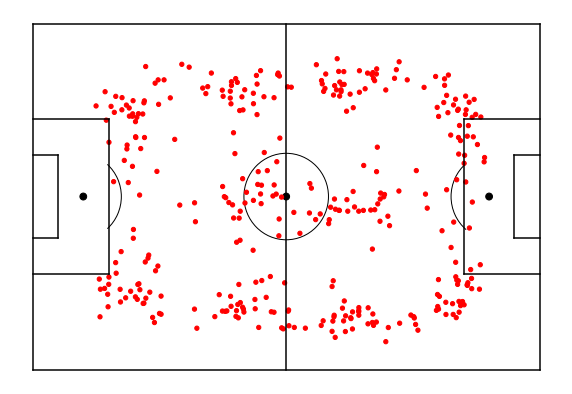

In [23]:
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
for formation in centroids:
    for location in formation:
        event = plt.Circle((location[0],pitchWidthY-location[1]),0.5,color='red')
        ax.add_patch(event)
fig.set_size_inches(10, 7)
plt.show()

Ya se puede aplicar el algoritmo de clustering aglomerante sobre esos grupos de centroides para saber cuál es el número de clústeres ideal. Se probará con un número máximo de 10 grupos y se representarán las puntuaciones obtenidas para cada métrica con cada número de clústeres.

In [24]:
def ideal_agglomerative(data, n_grupos=10, metrica=calinski_harabasz_score):
    resultados = []
    for n in range(2, n_grupos+1):
        cluster = AgglomerativeClustering(n_clusters=n).fit(data)
        resultados.append(metrica(data, cluster.labels_))
    serie = pd.Series(resultados, index=range(2, n_grupos+1))
    serie.plot()
    plt.show()

Pero antes es necesario aplanar las coordenadas para pasar a la función de Scikit-learn un array bidimensional en lugar del tridimensional que se tiene en esta parte. El resultado será una colección con tantas filas como partidos se incluyan en el dataset y con 20 columnas; siendo las impares para las coordenadas x y las pares para las y. Se debe tener en cuenta que las primeras dos columnas deben ser para el lateral izquierdo y las dos últimas para uno de los delanteros, por ejemplo.

In [25]:
# Se divide el campo en cuatro partes horizontales para dividir los puntos. Dentro de cada una de esas franjas de ordenarán de izquierda a derecha.
def order_centroids(centroids):
    aux = {'first': [], 'second': [], 'third': [], 'fourth': []}
    # Diferenciamos por zona del campo
    for point in centroids:
        x = point[0]
        y = point[1]
        if x >= 0 and x <= 30:
            aux['first'].append((x,y))
        elif x > 30 and x <= 60:
            aux['second'].append((x,y))
        elif x > 60 and x <= 90:
            aux['third'].append((x,y))
        elif x > 90 and x <= 120:
            aux['fourth'].append((x,y))
        else:
            print('Punto fuera de los límites')
    # Ordenación
    for key in aux.keys():
        aux[key] = sorted(aux[key], key=lambda tup: tup[1])
    # Aplanamos el diccionario en una lista de tuplas y, luego, en una lista de valores
    all_tuples = list(x for v in aux.values() for x in v)
    res = [x for v in all_tuples for x in v]
    return res

In [26]:
centroids_for_agglo = []
for group in centroids:
    centroids_for_agglo.append(order_centroids(group))

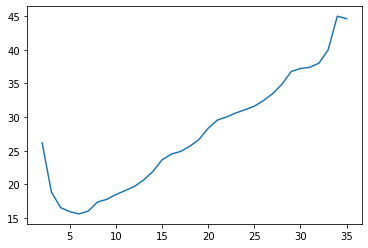

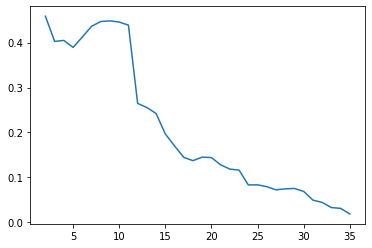

In [27]:
ideal_agglomerative(centroids_for_agglo,n_grupos=35)
ideal_agglomerative(centroids_for_agglo,n_grupos=35,metrica=silhouette_score)

Al realizar ese cambio ya es posible aplicar el algoritmo de clustering aglomerante. Los resultados difieren: mientras que el índice de Calinski-Harabasz expone que existen 35 estrategias diferentes en la temporada, el coeficiente de Silhouette indica solo 10 (se debe tener en cuenta que el resultado puede variar en función de lo que devuelva el algoritmo de K-medias).

Partiendo de la hipótesis por la que la evaluación mediante Silhouette es la correcta, se va a continuar el experimento con la idea que se obtiene de ese resultado: el F.C. Barcelona usó en torno a 10 planteamientos diferentes durante esa temporada.

In [28]:
centroids_represent = []
for c in centroids_for_agglo:
    points = []
    for i in range(0,len(c)-1,2):
        points.append([c[i],c[i+1]])
    centroids_represent.append(points)

Comprobamos que la transformación se hace correctamente.

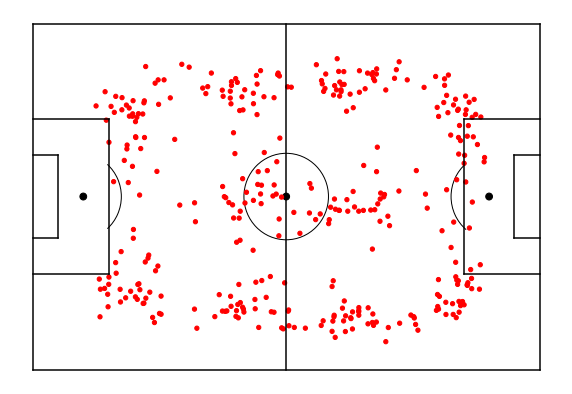

In [29]:
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
for formation in centroids_represent:
    for location in formation:
        event = plt.Circle((location[0],pitchWidthY-location[1]),0.5,color='red')
        ax.add_patch(event)
fig.set_size_inches(10, 7)
#fig.savefig('visual/clasification_agglo_all.png')
plt.show()

Mediante esa representación es díficil sacar nada en claro por lo que se diferencian los puntos por colores en función de a qué grupos pertenezcan.

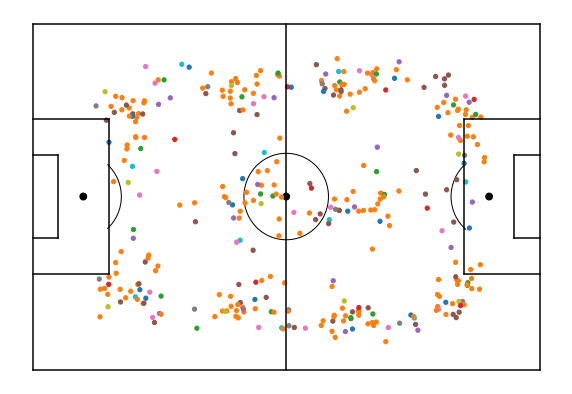

In [30]:
cluster_selection = AgglomerativeClustering(n_clusters=10).fit(centroids_for_agglo)
points_and_centers = zip(centroids_for_agglo,cluster_selection.labels_)
# Representación
(fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
for formation in points_and_centers:
    positions = formation[0]
    label = formation[1]
    for i in range(0,len(positions)-1,2):
        event = plt.Circle((positions[i],pitchWidthY-positions[i+1]),0.5,color=colors[label])
        ax.add_patch(event)
fig.set_size_inches(10, 7)
# fig.savefig('visual/clasification_agglo_by_color.png')
plt.show()

Convertimos a coordenadas junto a la *label* que indica el tipo de formación. Para mayor comodidad introduzco los datos en una lista.

In [31]:
centroids_and_labels = []
for formation in points_and_centers:
    res = [formation[1]]
    positions = []
    alin = formation[0]
    for i in range(0,len(alin)-1,2):
        res.append((alin[i],alin[i+1]))
    centroids_and_labels.append(res)

Se procede a hacer la media de las coordenadas por cada *label*. Esto es posible gracias a que las coordenadas se organizaron atendiendo a un orden establecido previamente.

**La siguiente celda puede modificar todas las interpretaciones realizadas en el resto del experimento. Por lo tanto, si se quiere mantener la consistencia se debe ejecutar la celda posterior, diseñada para recuperar los datos de un archivo con los datos correctos.**

In [14]:
df_centroids = pd.DataFrame(data=centroids_and_labels,columns=['label','1','2','3','4','5','6','7','8','9','10'])
centroids_mean = dict()
for l in range(0,10):
    df_centroids_label = df_centroids[df_centroids['label'] == l]
    df_mean = df_centroids_label[['1','2','3','4','5','6','7','8','9','10']]
    means = []
    for i in range(0,10):
        df_to_array = np.vstack(df_mean.to_numpy()[:, i]).astype(float)
        m = np.mean(df_to_array,axis=0)
        means.append((m[0],m[1]))
    centroids_mean[l] = means
    
# Guardar en un fichero para reutilizar
def write_unique_formations(centroids_mean, season):
    file_name = 'data/unique_formations_' + str(season.replace('/','_')) + '.json'
        with open(file_name, 'w') as f:
    json.dump(centroids_mean, f)

In [32]:
def read_unique_formations(file_name='data/unique_formations_1718.json'):
    with open(file_name, 'r') as f:
        centroids_mean = json.load(f)
    return centroids_mean

centroids_mean = read_unique_formations()

Solo queda representar los 10 tipos de estrategias del F.C. Barcelona.

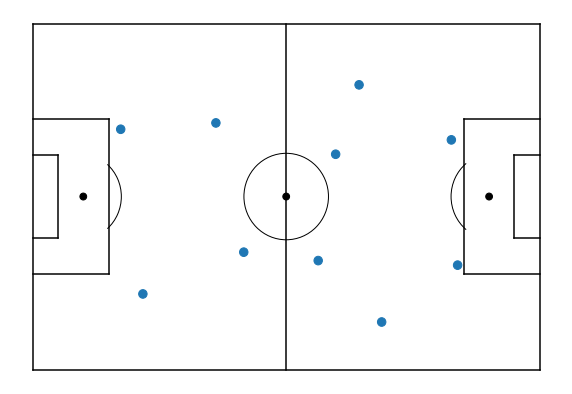

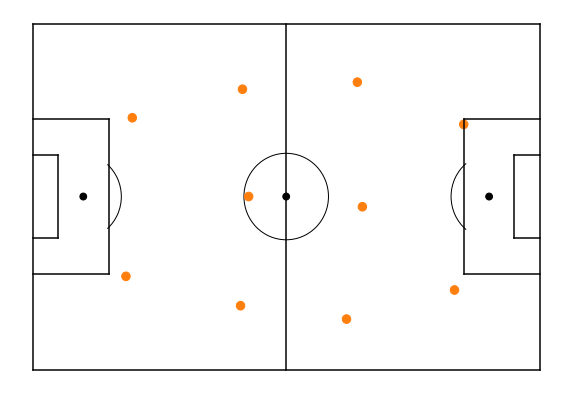

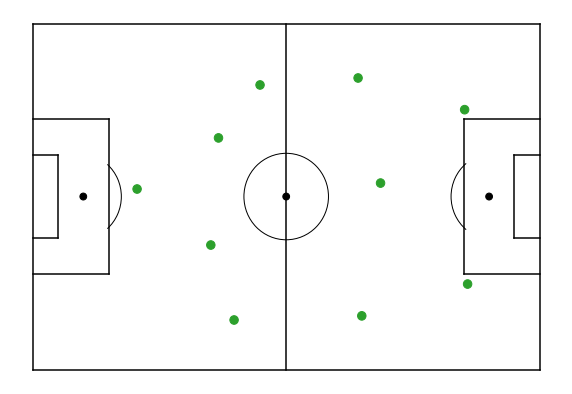

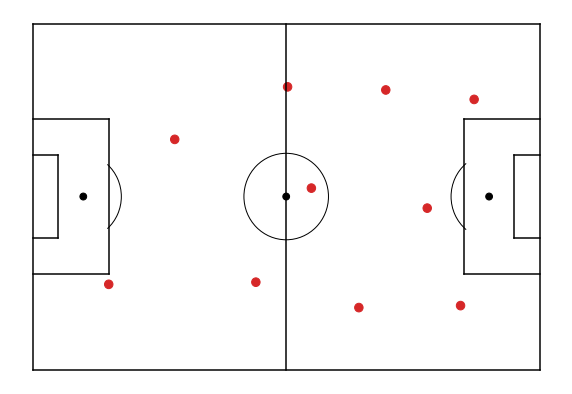

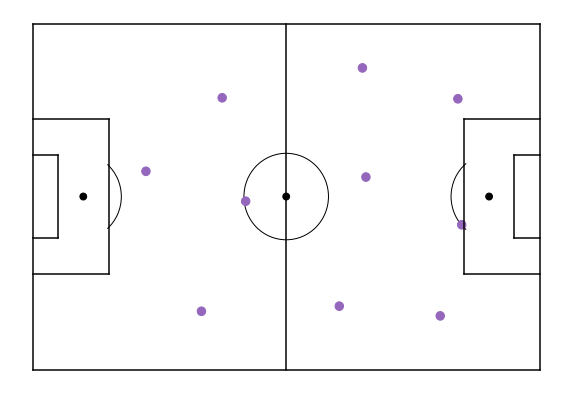

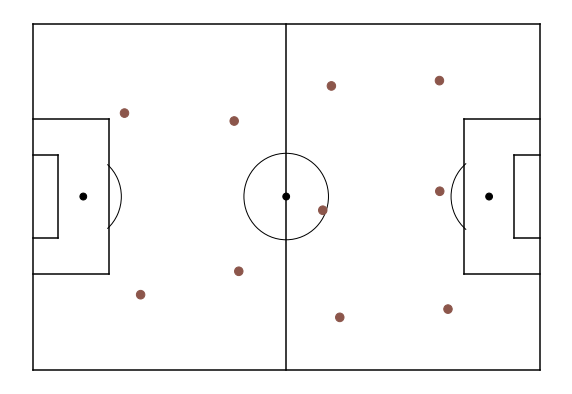

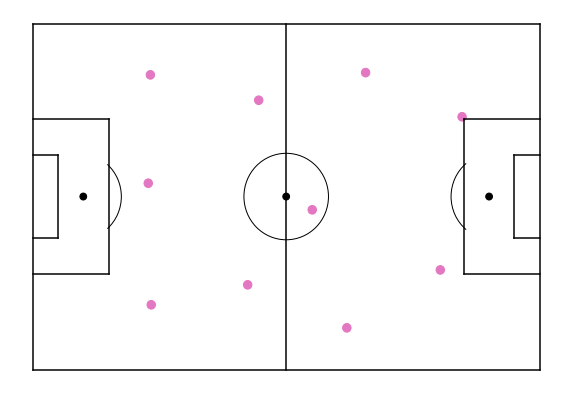

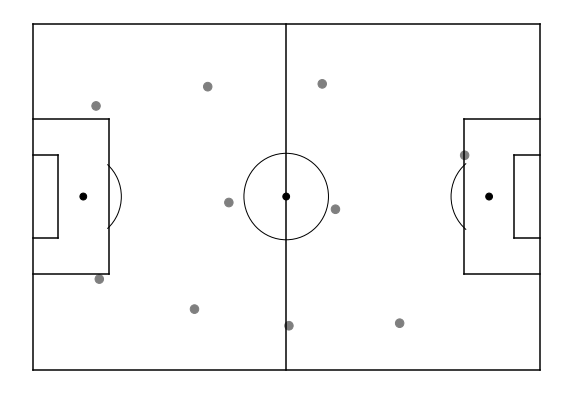

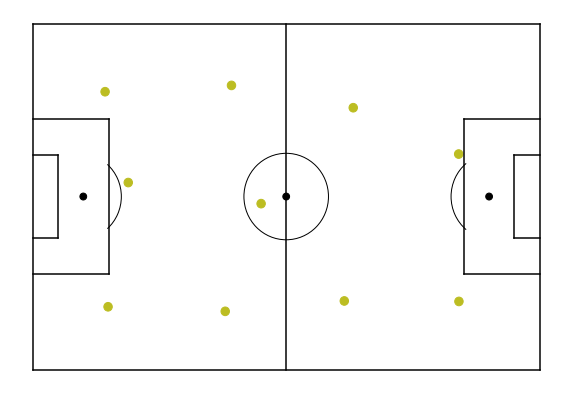

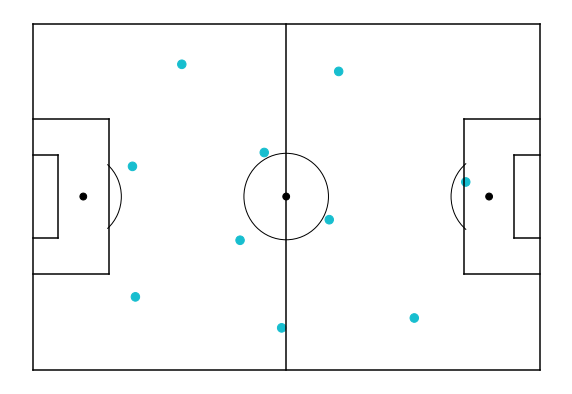

In [33]:
# Representación
for item in centroids_mean.items():
    (fig,ax) = createPitch(pitchLengthX,pitchWidthY,'yards','black')
    positions = item[1]
    label = item[0]
    for coords in positions:
        event = plt.Circle((float(coords[0]),pitchWidthY-float(coords[1])),1,color=colors[int(label)])
        ax.add_patch(event)
    fig.set_size_inches(10, 7)
    # fig.savefig('visual/unique_formations/formation_'+str(label)+'.png')
    plt.show()

Con las formaciones única identificadas se procede a relacionar cada partido (su planteamiento) con alguna de ellas. Se realiza buscando minimizar la distancia euclídea entre cada posición de un determinado partido con su igual dentro de las de las 10 estrategias encontradas.

In [34]:
# Preparación de los datos
centroids = read_centroids()
matches_info = list(zip(match_ids,centroids))

In [35]:
# Función para medir distancias
def formation_distance(match_centroids, unique_formation):
    distances = 0
    ordered_match_centroids = order_centroids(match_centroids)
    for i in range(0,10):
        dif = np.linalg.norm(np.array(unique_formation[i])-np.array(ordered_match_centroids[i]))
        distances += dif
    return distances

def ideal_formation(positions, unique_formations):
    res = 0
    actual = None
    for formation in unique_formations.items():
        distances = formation_distance(positions,formation[1])
        if actual == None or distances < actual:
            res = formation[0]
            actual = distances
    return res

In [36]:
match_formation_classification = []
for match in matches_info:
    label = ideal_formation(match[1],centroids_mean)
    match_formation_classification.append((match[0],label))

# Agrupamos por alineación
match_and_label = pd.DataFrame(data=match_formation_classification,columns=['match_id','label'])
match_and_label.groupby(by='label').count()

,match_id
label,
6,1
7,27
8,2
9,6


El sistema únicamente ha sido capaz de relacionar los 36 partidos de la temporada con las estrategias 6, 7, 8 y 9. Además, respecto a las que si han encontrado coincidencias, tres cuartas partes de los partidos se clasifican dentro de la formación etiquetada con el 7. Podría parecer que la mayoría de los planteamientos identificados representados no sirven, aunque pueden considerarse como variantes de la 6, 7, 8 o 9. Esta interpretación casa con la hipótesis de que un equipo de fútbol usa pocas alineaciones durante una temporada (tres en este caso), con algunas variaciones de esas mismas.